In [1]:
# Setup and Imports
import os
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Prefer an installed SDK. If running from repo without install, fall back to ../src.
try:
    from aipricepatterns import Client
except ImportError:
    repo_src = (Path.cwd() / ".." / "src").resolve()
    sys.path.append(str(repo_src))
    from aipricepatterns import Client

# Initialize Client (local instance or production)
# For production use: https://aipricepatterns.com/api/rust
# For local use: http://localhost:8787
BASE_URL = os.getenv("AIPP_BASE_URL", "https://aipricepatterns.com/api/rust")
API_KEY = os.getenv("AIPP_API_KEY")

client = Client(base_url=BASE_URL, api_key=API_KEY)
print(f"Connected to AI Price Patterns Engine at {BASE_URL}")

Connected to AI Price Patterns Engine at https://aipricepatterns.com/api/rust


## Part 1: Idea Generation (Pattern Search)

We want to analyze the current market structure of **BTCUSDT**. 
- **q=40**: We look at the last 60 hours (pattern length).
- **f=24**: We want to forecast the next 24 hours.
- **top_k=5**: We want the 5 most similar historical instances.

In [ ]:
SYMBOL = "BTCUSDT"
INTERVAL = "1h"

# 1. Search for patterns
search_results = client.search(
    symbol=SYMBOL,
    interval=INTERVAL,
    q=40,
    f=24,
    top_k=5
)

print(f"Found {len(search_results.get('matches', []))} historical analogues.")

# Display metrics
if 'forecast' in search_results and search_results['forecast'] and search_results['forecast'].get('median'):
    fc = search_results['forecast']
    meta = search_results.get('meta', {})
    last_price = meta.get('lastPrice')

    if last_price:
        # Calculate percentage changes from absolute price paths
        # The API returns absolute price paths for median, p90, etc.
        median_price = fc['median'][-1]
        p90_price = fc['p90'][-1]

        median_pct = ((median_price - last_price) / last_price) * 100
        p90_pct = ((p90_price - last_price) / last_price) * 100

        print(f"Forecast (Median): {median_pct:.2f}%")
        print(f"Forecast (P90 Bull Case): {p90_pct:.2f}%")
    else:
        print("Could not calculate percentages (missing lastPrice).")
else:
    print("No forecast available (not enough matches).")

Found 5 historical analogues.
Forecast (Median): 1.44%
Forecast (P90 Bull Case): 3.78%


## Part 1.5: Detailed Pattern Metrics (Scenario Analysis)

This section demonstrates the `/api/patterns/metrics` endpoint. 
This endpoint performs a search for the **current market situation** (latest candles) and returns detailed statistical distributions of the outcomes. 

It is used on the frontend to render:
- **Fan Charts / Probability Cones**: Using the `distribution` and `sigmaLevels` data.
- **Scenario Planning**: Showing Best/Worst case scenarios based on historical matches.

In [3]:
# 1.5 Get Detailed Pattern Metrics
# This endpoint is used to get detailed statistics about the current pattern match,
# including probability distributions and specific match metrics.

metrics_response = client.get_pattern_metrics(
    symbol=SYMBOL,
    interval=INTERVAL,
    q=40,
    f=24
)

print("--- Pattern Metrics Summary ---")
if 'metrics' in metrics_response and metrics_response['metrics']:
    m = metrics_response['metrics']
    print(f"Average Return: {m['averagePct']:.2f}%")
    print(f"Win Rate (Up Prob): {m['upProbPct']:.2f}%")
    print(f"Best Case: {m['bestPct']:.2f}%")
    print(f"Worst Case: {m['worstPct']:.2f}%")
else:
    print("No metrics summary available.")

print("\n--- Forecast Distribution ---")
if 'distribution' in metrics_response and metrics_response['distribution']:
    d = metrics_response['distribution']
    print(f"Samples: {d['samples']}")
    # Note: 'mean', 'stdev' here are absolute price values or relative depending on API version.
    # Usually for distribution stats in this endpoint, they are price levels.
    print(f"Mean Forecast Level: {d['mean']:.2f}")
    print(f"Stdev: {d['stdev']:.2f}")
else:
    print("No distribution data available.")

--- Pattern Metrics Summary ---
Average Return: 0.17%
Win Rate (Up Prob): 50.00%
Best Case: 9.90%
Worst Case: -3.72%

--- Forecast Distribution ---
Samples: 50
Mean Forecast Level: 1.40
Stdev: 2.44


### Visualization: Probability Fan Chart

We can visualize the forecast distribution using a **Fan Chart**. This shows the range of probable outcomes derived from the historical analogues:
- **Light Blue Area**: 80% probability range (P10 to P90)
- **Dark Blue Area**: 50% probability range (P25 to P75)
- **White/Red Line**: Median forecast

This visualization helps traders understand the *uncertainty* and *skew* of the current setup.

Fetching details for 5 top matches to plot trajectories...


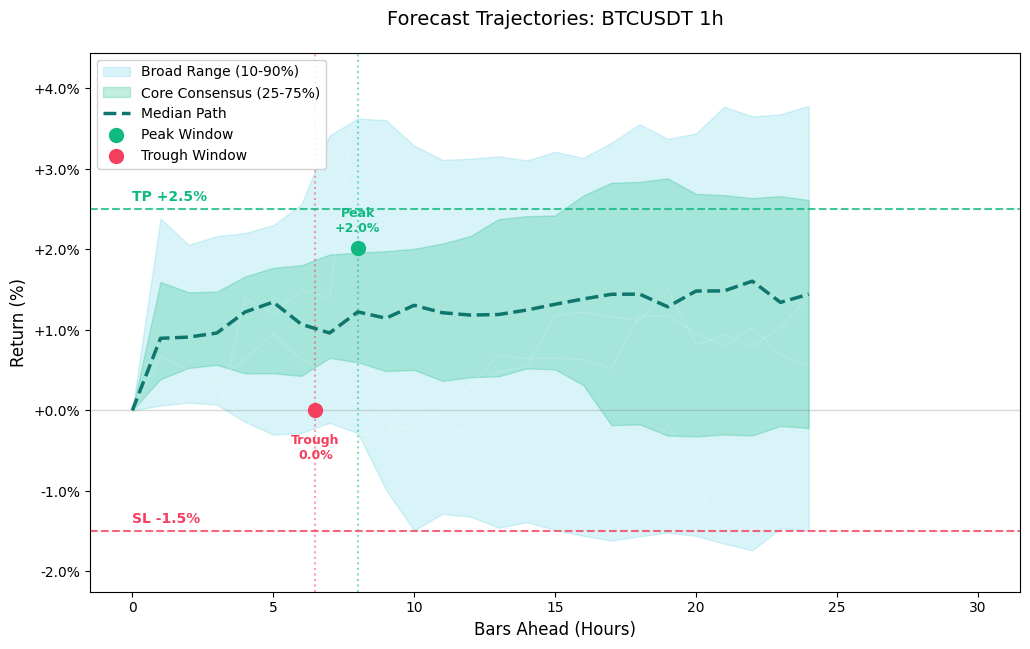

In [ ]:
import numpy as np
try:
    import seaborn as sns
    sns.set_theme(style="darkgrid")
except Exception:
    sns = None


# Ensure we have data
if 'search_results' in locals() and 'forecast' in search_results:
    fc = search_results['forecast']

    # Check if we have metrics from the previous step (for Peak/Trough timing)
    metrics = {}
    dist = {}
    if 'metrics_response' in locals():
        metrics = metrics_response.get('metrics', {})
        dist = metrics_response.get('distribution', {})

    plt.figure(figsize=(12, 7))

    # --- NEW: Plot Individual Historical Paths (Spaghetti) ---
    # This replicates the "Forecast Trajectories" UI component by showing
    # the actual historical outcomes that form the distribution.

    matches = search_results.get('matches', [])[:10] # Top 10 matches
    q_len = globals().get("Q", 40)  # From our search params (fallback if Q not defined)

    print(f"Fetching details for {len(matches)} top matches to plot trajectories...")

    for m in matches:
        try:
            # Fetch full series data for the match
            details = client.get_match_details(m['id'])
            if 'series' in details:
                full_series = details['series']
                # The series contains [query_window ... forecast_window]
                # We want to start from the "detection point" (last candle of query)
                # Index of last query point is q - 1
                start_idx = max(0, q_len - 1)

                if len(full_series) > start_idx:
                    future_path = full_series[start_idx:]
                    base_val = future_path[0]

                    # Normalize to percentage change from detection point
                    path_pct = [(x - base_val) / base_val * 100 for x in future_path]

                    # Plot faint line
                    plt.plot(np.arange(len(path_pct)), path_pct, color='white', alpha=0.15, linewidth=1)
        except Exception as e:
            print(f"Skipping match {m['id']}: {e}")

    # ---------------------------------------------------------

    # 1. Prepare Data: Convert Absolute Prices to Percentages
    # The forecast arrays include t=0 (current price) up to t=f
    base_price = fc['median'][0]

    def to_pct(arr):
        return np.array([(x - base_price) / base_price * 100 for x in arr])

    median_pct = to_pct(fc['median'])
    p10_pct = to_pct(fc['p10'])
    p25_pct = to_pct(fc['p25'])
    p75_pct = to_pct(fc['p75'])
    p90_pct = to_pct(fc['p90'])

    steps = len(median_pct)
    x_axis = np.arange(steps)

    # 2. Plot Fan (Confidence Intervals) - Matching UI Colors
    # P10-P90 (80% Confidence) - Cyan
    plt.fill_between(x_axis, p10_pct, p90_pct, color='#06b6d4', alpha=0.15, label='Broad Range (10-90%)')

    # P25-P75 (50% Confidence) - Emerald/Teal
    plt.fill_between(x_axis, p25_pct, p75_pct, color='#10b981', alpha=0.25, label='Core Consensus (25-75%)')

    # Median Path - Dark Teal
    plt.plot(x_axis, median_pct, color='#0f766e', linewidth=2.5, linestyle='--', label='Median Path')

    # 3. Add Markers (Peak/Trough Windows)
    if metrics and dist:
        # Calculate median peak/trough levels from distribution
        if 'pathMaxes' in dist and dist['pathMaxes']:
            peak_level = np.median(dist['pathMaxes'])
            peak_time = metrics.get('medianTimeToPeakBars', 0)

            plt.scatter([peak_time], [peak_level], color='#10b981', s=100, zorder=5, label='Peak Window')
            plt.text(peak_time, peak_level + 0.2, f"Peak\n+{peak_level:.1f}%",
                     color='#10b981', fontsize=9, ha='center', fontweight='bold')

            # Vertical line for Peak Window
            plt.axvline(x=peak_time, color='#10b981', linestyle=':', alpha=0.5)

        if 'pathMins' in dist and dist['pathMins']:
            trough_level = np.median(dist['pathMins'])
            trough_time = metrics.get('medianTimeToTroughBars', 0)

            plt.scatter([trough_time], [trough_level], color='#f43f5e', s=100, zorder=5, label='Trough Window')
            plt.text(trough_time, trough_level - 0.6, f"Trough\n{trough_level:.1f}%",
                     color='#f43f5e', fontsize=9, ha='center', fontweight='bold')

            # Vertical line for Trough Window
            plt.axvline(x=trough_time, color='#f43f5e', linestyle=':', alpha=0.5)

    # 4. Add TP/SL Levels (Example: +2.5% / -1.5%)
    plt.axhline(y=2.5, color='#10b981', linestyle='--', alpha=0.8, linewidth=1.5)
    plt.text(0, 2.6, "TP +2.5%", color='#10b981', fontsize=10, fontweight='bold')

    plt.axhline(y=-1.5, color='#f43f5e', linestyle='--', alpha=0.8, linewidth=1.5)
    plt.text(0, -1.4, "SL -1.5%", color='#f43f5e', fontsize=10, fontweight='bold')

    # Zero Line
    plt.axhline(y=0, color='gray', linewidth=1, alpha=0.3)

    plt.title(f"Forecast Trajectories: {SYMBOL} {INTERVAL}", fontsize=14, pad=20)
    plt.xlabel("Bars Ahead (Hours)", fontsize=12)
    plt.ylabel("Return (%)", fontsize=12)
    plt.legend(loc='upper left', frameon=True, facecolor='white', framealpha=0.9)

    # Format Y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:+.1f}%"))

    if sns is not None:
        sns.despine()
    plt.show()
else:
    print("No forecast data available to plot.")

## Part 2: The "Honest" Backtest (Validation)

Finding a pattern is easy. Proving it works is hard.

We run a **Walk-Forward Backtest**. The engine "time-travels" through history. At every step, it only uses data available *before* that moment to find matches and make a decision. This eliminates look-ahead bias.

In [5]:
# 2. Run Walk-Forward Backtest
import os

print("Running Walk-Forward Simulation... (this may take a few seconds)")

FEE_PCT = float(os.getenv("AIPP_FEE_PCT", "0.04"))  # percent, e.g. 0.04 means 0.04%
SLIPPAGE_PCT = float(os.getenv("AIPP_SLIPPAGE_PCT", "0.00"))

backtest = client.backtest(
    symbol=SYMBOL,
    interval=INTERVAL,
    q=30,
    f=12,
    step=12,  # Check every 12 bars (interval=1h → 12 hours)
    min_prob=0.9,  # Only trade if ≥90% confidence
    include_stats=True,
    fee_pct=FEE_PCT,
    slippage_pct=SLIPPAGE_PCT,
)

stats = backtest["stats"]
print("\n--- Backtest Results ---")
print(f"Total Return:      {stats['totalReturnPct']:.2f}%")
print(f"Sharpe Ratio:      {stats['sharpeRatio']:.2f}")
print(f"Max Drawdown:      {stats['maxDrawdownPct']:.2f}%")
print(f"Win Rate:          {stats['winRate']:.2f}%")
print(f"Profit Factor:     {stats['profitFactor']:.2f}")


Running Walk-Forward Simulation... (this may take a few seconds)

--- Backtest Results ---
Total Return:      134.84%
Sharpe Ratio:      0.82
Max Drawdown:      24.89%
Win Rate:          51.96%
Profit Factor:     1.27


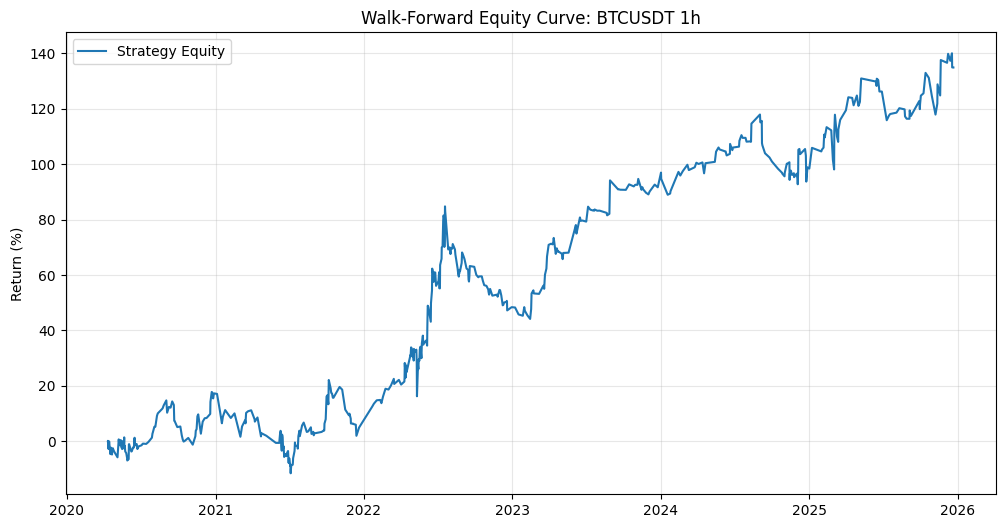

In [6]:
# 3. Visualize Equity Curve
equity_df = client.equity_curve_to_df(backtest)

if not equity_df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(equity_df.index, equity_df['value'], label='Strategy Equity')
    plt.title(f"Walk-Forward Equity Curve: {SYMBOL} {INTERVAL}")
    plt.ylabel("Return (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("No trades were taken in the simulation period.")

## Part 2.5: Specific Pattern Backtest (Deep Dive)

Sometimes you want to analyze how a **specific historical moment** would have performed if traded using this strategy. 

The `/api/patterns/backtest/specific` endpoint allows you to "replay" a specific point in time (defined by a timestamp) to see:
- What matches would have been found *at that exact moment*.
- What the forecast was.
- What the *actual* outcome was (since we now know the future).

This is crucial for auditing specific trade signals.

In [ ]:
# 2.5 Run Specific Pattern Backtest
# We analyze a specific timestamp (e.g., March 2024) to see how the model performed.

specific_timestamp = 1709942400000  # Example timestamp (Mar 9, 2024, UTC)

print(f"Analyzing specific pattern at timestamp: {specific_timestamp}")

specific_result = client.backtest_specific_pattern(
    symbol=SYMBOL,
    interval=INTERVAL,
    q=24,
    f=12,
    timestamp=specific_timestamp,
    fee_pct=0.04,
    slippage_pct=0.02,
    include_stats=True
)

if 'outcome' in specific_result:
    outcome = specific_result['outcome']
    print("\n--- Specific Trade Outcome ---")
    print(f"Actual Return:     {outcome.get('actualReturnPct', 0):.2f}%")
    print(f"Signal Confidence: {specific_result.get('metrics', {}).get('upProbPct', 0):.2f}%")

    # Check if it was a win or loss
    is_win = outcome.get('actualReturnPct', 0) > 0
    print(f"Result:            {'✅ WIN' if is_win else '❌ LOSS'}")

    if 'forecast' in specific_result:
        print(f"Forecasted Median: {specific_result['forecast']['median'][-1]:.2f} (Absolute Price)")
else:
    print("Could not analyze specific pattern (data might be missing for this timestamp).")

Analyzing specific pattern at timestamp: 1709942400000
Could not analyze specific pattern (data might be missing for this timestamp).


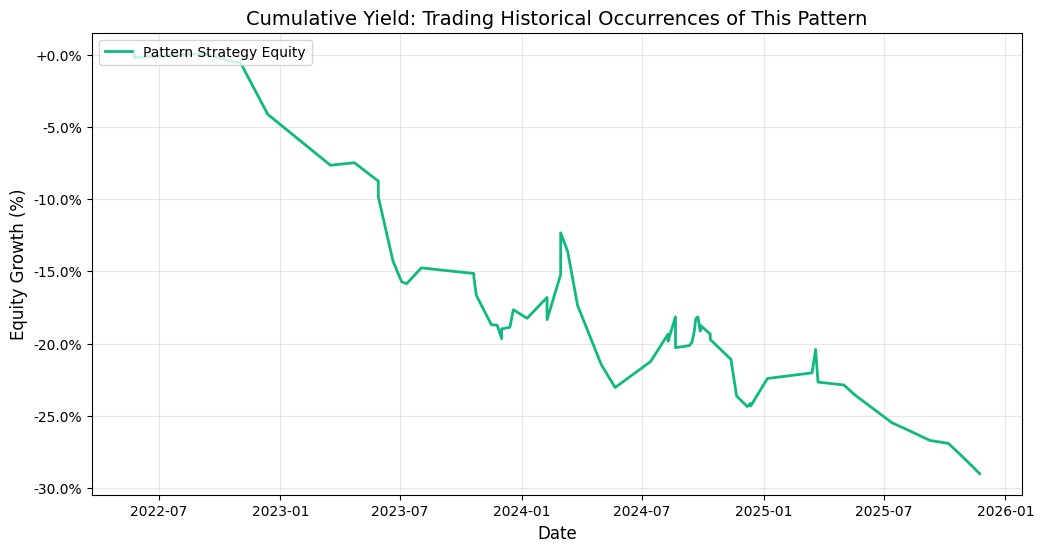

Total Historical Trades: 63
Win Rate: 36.51%
Profit Factor: 0.46


In [ ]:
# 2.6 Visualize Specific Pattern Performance (Yield Graph)
# This graph shows the cumulative equity if you had traded EVERY historical occurrence
# of this specific pattern found in the database.

if 'stats' in specific_result and specific_result['stats']:
    stats = specific_result['stats']
    equity_curve = stats.get('equityCurve', [])

    if equity_curve:
        # Convert to DataFrame for easier plotting
        df_equity = pd.DataFrame(equity_curve)
        df_equity['date'] = pd.to_datetime(df_equity['ts'], unit='ms')
        df_equity.set_index('date', inplace=True)

        plt.figure(figsize=(12, 6))

        # Plot Equity Curve
        plt.plot(df_equity.index, df_equity['value'], color='#10b981', linewidth=2, label='Pattern Strategy Equity')

        plt.title(f"Cumulative Yield: Trading Historical Occurrences of This Pattern", fontsize=14)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Equity Growth (%)", fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)

        # Format Y-axis
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:+.1f}%"))

        plt.show()

        print(f"Total Historical Trades: {stats['totalTrades']}")
        print(f"Win Rate: {stats['winRate']:.2f}%")
        print(f"Profit Factor: {stats['profitFactor']:.2f}")
    else:
        print("No equity curve data available.")
else:
    print("No statistics available for this specific pattern backtest.")

## Part 3: Risk Management (Grid Stats)

Institutional traders need to know the **Sigma Levels**—the probabilistic boundaries of price movement based on historical volatility of similar patterns.

In [9]:
# 4. Get Grid / Risk Stats
grid_stats = client.get_grid_stats(SYMBOL, INTERVAL)

print("--- Risk Profile ---")
if 'riskProfile' in grid_stats and grid_stats['riskProfile']:
    print(f"Expected Drawdown: {grid_stats['riskProfile']['expectedDrawdownPct']}%")
    print(f"Risk/Reward Ratio: {grid_stats['riskProfile']['riskRewardRatio']}")
else:
    print("Risk profile not available.")

print("\n--- Sigma Levels (Probabilistic Support/Resistance) ---")
if 'sigmaLevels' in grid_stats:
    for level in grid_stats['sigmaLevels']:
        # level contains 'k', 'label', 'positive', 'negative', etc.
        print(f"{level['label']} Range: [{level['negative']:.2f}%, {level['positive']:.2f}%]")
else:
    print("Sigma levels not available.")

--- Risk Profile ---
Expected Drawdown: -2.3169%
Risk/Reward Ratio: 1.6035

--- Sigma Levels (Probabilistic Support/Resistance) ---
1σ Range: [-1.34%, 4.36%]
2σ Range: [-4.19%, 7.20%]
3σ Range: [-7.04%, 10.05%]


## Part 4: Integration with ML Pipelines (RL)

You can use the API to fetch training data for Reinforcement Learning agents. We provide flattened arrays of `states`, `rewards`, and `next_states` derived from historical analogues.

In [10]:
# 5. Fetch RL Training Batch
batch = client.get_rl_training_batch(
    symbol=SYMBOL,
    interval=INTERVAL,
    batch_size=100
)

print(f"Fetched {batch['meta']['totalEpisodes']} episodes for training.")
print(f"Feature Dimension: {batch['meta']['featureDim']}")

# Example: Accessing raw state vectors
# import numpy as np
# states = np.array(batch['data']['states'])
# print(states.shape)

Fetched 100 episodes for training.
Feature Dimension: 40


## Part 5: Market Regimes (Context-Aware Trading)

Strategies often fail because they don't adapt to changing market conditions. A "Trend Following" strategy dies in a "Range Bound" market.

The API provides a **Regime Detection** module that classifies the current market state into categories like:
- **Trend Continuation**
- **Mean Reversion**
- **High Volatility Breakout**
- **Range Bound**

This allows you to switch strategies dynamically.

In [11]:
# 6. Detect Market Regimes

# Get list of all defined regimes
regimes_info = client.get_rl_regimes(SYMBOL, INTERVAL)
print("--- Defined Market Regimes ---")
for r in regimes_info.get('regimes', []):
    print(f"[{r['id']}] {r['description']} (Freq: {r['frequency']*100:.1f}%)")

# Detect CURRENT regime
current_regime = client.get_current_regime(SYMBOL, INTERVAL)
print("\n--- Current Market State ---")
if 'currentRegime' in current_regime and current_regime['currentRegime']:
    cr = current_regime['currentRegime']
    print(f"Detected Regime: {cr['id'].upper()}")
    print(f"Confidence:      {cr['confidence']*100:.1f}%")
else:
    print("Could not detect current regime (insufficient data or model not ready).")

--- Defined Market Regimes ---
[high_volatility_breakout] Volatility compression followed by explosive move (Freq: 12.0%)
[mean_reversion] Extended deviation from moving average with reversion (Freq: 28.0%)
[trend_continuation] Established trend with pullback entry (Freq: 22.0%)
[range_bound] Sideways consolidation with clear support/resistance (Freq: 25.0%)
[capitulation] Panic selling followed by absorption (Freq: 8.0%)
[blow_off_top] Parabolic rise followed by sharp reversal (Freq: 5.0%)

--- Current Market State ---
Detected Regime: MEAN_REVERSION
Confidence:      70.0%


In [ ]:
# 6.5 Detect Regime for Specific Historical Moment
# We can also check what the regime was during our specific backtest timestamp (March 2024)

# Ensure variables are defined if running out of order
if 'specific_timestamp' not in locals():
    specific_timestamp = 1709942400000  # Example timestamp (Mar 9, 2024, UTC)

print(f"Detecting regime for timestamp: {specific_timestamp}")
historical_regime = client.detect_regime(
    symbol=SYMBOL,
    interval=INTERVAL,
    timestamp=specific_timestamp
)

if 'currentRegime' in historical_regime and historical_regime['currentRegime']:
    hr = historical_regime['currentRegime']
    print(f"Historical Regime: {hr['id'].upper()}")
    print(f"Confidence:        {hr['confidence']*100:.1f}%")

    # Compare with outcome if available
    if 'specific_result' in locals() and 'outcome' in specific_result:
        actual_ret = specific_result['outcome'].get('actualReturnPct', 0)
        print(f"Actual Return:     {actual_ret:.2f}%")

        if hr['id'] == 'mean_reversion' and abs(actual_ret) < 2.0:
             print("Observation: Regime was Mean Reversion, and price indeed stayed within range.")
        elif hr['id'] == 'high_volatility_breakout' and abs(actual_ret) > 5.0:
             print("Observation: Regime was Breakout, and price indeed moved significantly.")
else:
    print("Could not detect historical regime.")

Detecting regime for timestamp: 1709942400000
Historical Regime: BULLISH_MOMENTUM
Confidence:        90.0%


## Part 7: Interactive Pattern Exploration (Time Travel)

The UI uses the `/api/patterns-recalc` endpoint to allow users to "scroll" through history. This endpoint is optimized to quickly find patterns at a specific historical offset without re-downloading the entire dataset.

This is useful for:
- **Debugging**: "Why did the model predict UP here?"
- **Manual Backtesting**: Visually inspecting past signals.
- **Data Collection**: Gathering examples of specific setups.

In [ ]:
# 7. Explore Patterns at a Specific Historical Offset
# This mimics the UI behavior when you click on a past candle.

# Let's pick an offset (number of candles from the beginning of the dataset)
# You can find the total length from search_results['meta']['totalCandles'] if available,
# or just pick a known valid index.
historical_offset = 65602

print(f"Time-traveling to offset: {historical_offset}...")

recalc_results = client.recalc_patterns(
    symbol=SYMBOL,
    interval=INTERVAL,
    start=historical_offset,
    q=40,
    f=30,
    limit=10,
    sort="similarity",
    # Optional: restrict search window like the UI does
    # window_start_ts=1528934400000,
    # window_end_ts=1765857600000
)

print(f"Found {len(recalc_results.get('matches', []))} matches at offset {historical_offset}.")

if 'forecast' in recalc_results and recalc_results['forecast']:
    median_forecast = recalc_results['forecast']['median'][-1]
    print(f"Forecasted Price at that time: {median_forecast:.2f}")
else:
    print("No forecast available for this offset.")

Time-traveling to offset: 65602...
Found 10 matches at offset 65602.
Forecasted Price at that time: 88964.58


## Part 8: Institutional Workflow - Automated Post-Mortem & Stability Analysis

Hedge funds don't just want "signals", they want **robustness**. 
We have packaged advanced analysis tools into the SDK to automate:

1.  **Stability Analysis**: Does the signal disappear if we shift the window by 1 bar? (Sensitivity Check)
2.  **Automated Post-Mortem**: Analyzing the market regime during historical losses to identify weaknesses.


In [14]:
# Import the new analysis tools
from aipricepatterns import SignalStabilityAnalyzer, BacktestAuditor

# Initialize analyzers
analyzer = SignalStabilityAnalyzer(client)
auditor = BacktestAuditor(client)

print("Institutional Analysis Tools Initialized.")


Institutional Analysis Tools Initialized.


In [15]:
# 8.1 Signal Stability Check
# We check if the signal at our 'historical_offset' is robust.
# If shifting the window by 1-2 bars drastically changes the forecast, the signal is "fragile".

if 'historical_offset' not in locals():
    historical_offset = 65602 # Default if Part 7 wasn't run

print(f"Checking stability for offset {historical_offset}...")

stability_report = analyzer.check_stability(
    symbol=SYMBOL,
    interval=INTERVAL,
    base_offset=historical_offset,
    offsets=[0, 1, 2], # Check t, t-1, t-2
    q=40,
    f=30
)

print(f"Stable:     {'✅ YES' if stability_report['stable'] else '⚠️ NO'}")
print(f"Volatility: {stability_report['volatility']:.2f}")
print("\n--- Details (Forecasts at offsets) ---")
for d in stability_report['details']:
    if 'forecast_pct' in d:
        print(f"Offset -{d['offset']}h: {d['forecast_pct']:.2f}%")
    else:
        print(f"Offset -{d['offset']}h: No match found")


Checking stability for offset 65602...
Stable:     ✅ YES
Volatility: 0.00

--- Details (Forecasts at offsets) ---
Offset -0h: 1.28%
Offset -1h: 1.28%
Offset -2h: 1.28%


In [ ]:
# 8.2 Backtest Audit (Regime Analysis)
# We analyze the losing trades from our previous backtest to see if they cluster in specific regimes.
# This helps in defining "Regime Filters" (e.g., "Don't trade Mean Reversion strategies in Breakout regimes").

if 'backtest' in locals() and 'trades' in backtest:
    print("Auditing backtest results...")
    audit_report = auditor.analyze_losses(SYMBOL, INTERVAL, backtest['trades'])

    print(f"\nTotal Losses Analyzed: {audit_report['total_losses']}")
    print("Failures by Regime:")
    for regime, count in audit_report['regime_distribution'].items():
        print(f"- {regime}: {count} losses")

    if audit_report['regime_distribution']:
        worst_regime = max(audit_report['regime_distribution'], key=audit_report['regime_distribution'].get)
        print(f"\n🚫 RISK INSIGHT: Consider filtering trades during '{worst_regime}' regime.")
else:
    print("No backtest results found. Please run Part 2 first.")


No backtest results found. Please run Part 2 first.
